## Neural Machine Translation at Character-Level without Attention Mechanism

### Download and Prepare Dataset

Dataset downloaded from :  Dataset downloaded from: http://www.manythings.org/anki/deu-eng.zip

In [1]:
import tensorflow as tf
import re
import string
import numpy as np
from unicodedata import normalize
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [2]:
path_to_file = "dataset/deu.txt"
MAX_LINES = 20000

In [3]:
def load_data(filename):
    """ Return data set as a list of pair-list"""
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    lines = text.split('\n')
    pairs = [line.split('\t')[:2] for line in lines[:min(MAX_LINES, len(lines) - 1)]]
    return pairs

def clean_pairs(pairs):
    cleaned = list()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    for pair in pairs:
        clean_pair = []
        for line in pair:
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            line = line.split()
            line = [word.lower() for word in line]
            line = [re_punc.sub('', w) for w in line]
            line = [re_print.sub('', w) for w in line]
            line = [word for word in line if word.isalpha()]
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return cleaned

def encode_one_hot(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

def tokenizer(text):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', char_level=True)
    tokenizer.fit_on_texts(text)
    sequence = tokenizer.texts_to_sequences(text)
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post')
    return padded_sequence, tokenizer

In [4]:
pairs = load_data(path_to_file)
cleaned_pairs = clean_pairs(pairs)
en = [en for [en, ger] in cleaned_pairs]
ger = [ger for [en, ger] in cleaned_pairs]
ger = list(map(lambda x : '\t' +  x  + '\n' , ger))

In [5]:
# to change input/target language
input_lang = en
target_lang = ger

In [6]:
# padded sequence and tokenier of input/target language
input_seq, input_tokenizer = tokenizer(input_lang)
target_seq, target_tokenizer = tokenizer(target_lang)

# maximum length of input and target language
max_input_length = input_seq.shape[1]
max_target_length = target_seq.shape[1]

# vocab size of input/target language
input_vocab_size = len(input_tokenizer.word_index)+1
target_vocab_size = len(target_tokenizer.word_index)+1

In [7]:
# Input/output of encoder decoder

encoder_input_data = encode_one_hot(input_seq, input_vocab_size)
target_seq_one_hot = encode_one_hot(target_seq, target_vocab_size)
decoder_input_data = target_seq_one_hot[:,:-1,:]
decoder_output_data = target_seq_one_hot[:, 1:,:]

### Build a Model

In [78]:
LATENT_DIM = 128

# Define Encoder/Decoder

# Encoder
encoder_input = Input(shape=(None, input_vocab_size), 
                      name='encoder_input')
encoder_lstm = LSTM(LATENT_DIM, 
                    return_sequences=False, 
                    return_state=True, 
                    name='encoder_lstm')
_, enc_state_h, enc_state_c = encoder_lstm(encoder_input)
encoder_state = [enc_state_h, enc_state_c]

# Decoder
decoder_input = Input(shape=[None, target_vocab_size],
                     name='decoder_input')
decoder_lstm = LSTM(LATENT_DIM,
                   return_sequences=True,
                   return_state=True,
                   name='decoder_lstm')
dec_h_output, dec_state_h, dec_state_c = decoder_lstm(decoder_input,
                                                     initial_state=encoder_state,)
decoder_dense = Dense(target_vocab_size, 
                      activation='softmax', 
                      name='decoder_dense')
decoder_output = decoder_dense(dec_h_output)

# Model
model = Model([encoder_input, decoder_input],
              decoder_output,
             name='encoder_decoder_model')

In [79]:
model.compile(optimizer='adam', 
                               loss='categorical_crossentropy', 
                               metrics=['accuracy'])
model.summary()

Model: "encoder_decoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 28)]   0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 30)]   0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 128), (None, 80384       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 128),  81408       decoder_input[0][0]              
                                                                 encoder_lstm[

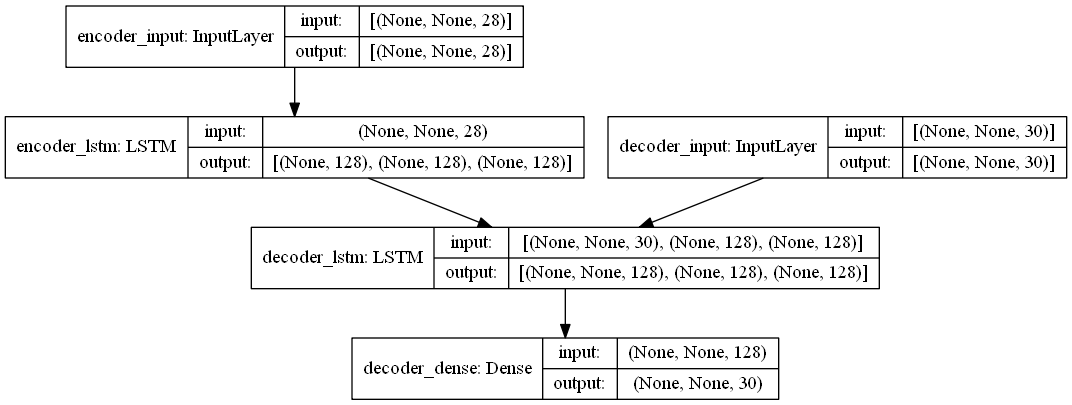

In [80]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [81]:
# Early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(patience=10,
                                              restore_best_weights=True)

In [82]:
history = model.fit([encoder_input_data, decoder_input_data], 
                                    decoder_output_data,
                                    epochs=100,
                                    validation_split=0.2,
                                    callbacks = [es_callback])
model.save('model_encoder_decoder_translation_char_level_no_attention.h5')

Epoch 1/100
500/500 [==============================] - 32s 59ms/step - loss: 0.7817 - accuracy: 0.7912 - val_loss: 0.6274 - val_accuracy: 0.8199
Epoch 2/100
500/500 [==============================] - 32s 64ms/step - loss: 0.4883 - accuracy: 0.8562 - val_loss: 0.5196 - val_accuracy: 0.8447
Epoch 3/100
500/500 [==============================] - 32s 63ms/step - loss: 0.4221 - accuracy: 0.8739 - val_loss: 0.4796 - val_accuracy: 0.8565
Epoch 4/100
500/500 [==============================] - 35s 69ms/step - loss: 0.3894 - accuracy: 0.8836 - val_loss: 0.4492 - val_accuracy: 0.8641
Epoch 5/100
500/500 [==============================] - 37s 73ms/step - loss: 0.3673 - accuracy: 0.8895 - val_loss: 0.4308 - val_accuracy: 0.8697
Epoch 6/100
500/500 [==============================] - 38s 75ms/step - loss: 0.3502 - accuracy: 0.8942 - val_loss: 0.4163 - val_accuracy: 0.8742
Epoch 7/100
500/500 [==============================] - 38s 77ms/step - loss: 0.3355 - accuracy: 0.8981 - val_loss: 0.4048 - val_ac

### Inference

In [83]:
target_tokenizer.word_index.items()

dict_items([(' ', 1), ('e', 2), ('i', 3), ('t', 4), ('n', 5), ('s', 6), ('h', 7), ('\t', 8), ('\n', 9), ('a', 10), ('r', 11), ('c', 12), ('m', 13), ('u', 14), ('o', 15), ('d', 16), ('g', 17), ('l', 18), ('b', 19), ('w', 20), ('f', 21), ('k', 22), ('z', 23), ('v', 24), ('p', 25), ('j', 26), ('y', 27), ('x', 28), ('q', 29)])

In [73]:
model = tf.keras.models.load_model("model_encoder_decoder_translation_char_level_no_attention.h5")

In [100]:
LATENT_DIM = 128

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(LATENT_DIM,))
decoder_state_input_c = keras.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

target_char_index = target_tokenizer.word_index
reverse_target_char_index = dict((i, char) for char, i in target_tokenizer.word_index.items())

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, target_vocab_size))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_char_index["\t"]] = 1.0
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
        
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_char_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_char_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_target_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, target_vocab_size))
        target_seq[0, 0, sampled_char_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [101]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("------------------------------------")
    print("Input sentence:", input_lang[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: go
Decoded sentence: gehen

-
Input sentence: hi
Decoded sentence: hallo

-
Input sentence: hi
Decoded sentence: hallo

-
Input sentence: run
Decoded sentence: versucht

-
Input sentence: run
Decoded sentence: versucht

-
Input sentence: wow
Decoded sentence: mangsam

-
Input sentence: wow
Decoded sentence: mangsam

-
Input sentence: fire
Decoded sentence: vergessen sie

-
Input sentence: help
Decoded sentence: schien sich vorsichen

-
Input sentence: help
Decoded sentence: schien sich vorsichen

-
Input sentence: stop
Decoded sentence: halte sie

-
Input sentence: stop
Decoded sentence: halte sie

-
Input sentence: wait
Decoded sentence: warte

-
Input sentence: wait
Decoded sentence: warte

-
Input sentence: begin
Decoded sentence: gehen sie

-
Input sentence: go on
Decoded sentence: gehen sie sich

-
Input sentence: hello
Decoded sentence: halleis

-
Input sentence: hello
Decoded sentence: halleis

-
Input sentence: hurry
Decoded sentence: schnell dich

-
Input sen